In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/fake-news-detection/fake_and_real_news.csv


# Fake News Detection System

## Importing Libraries

In [2]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import pandas as pd
import seaborn as sns
import pickle
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, auc, roc_auc_score
from nltk.tokenize import word_tokenize
from gensim.models import Word2Vec
from keras.models import Sequential
from keras.callbacks import ReduceLROnPlateau , EarlyStopping
from keras.layers import Dense, Dropout, Flatten

## Loading Dataset

In [3]:
data = pd.read_csv("/kaggle/input/fake-news-detection/fake_and_real_news.csv")

In [4]:
data.head()

,Text,label
0,Top Trump Surrogate BRUTALLY Stabs Him In The...,Fake
1,U.S. conservative leader optimistic of common ...,Real
2,"Trump proposes U.S. tax overhaul, stirs concer...",Real
3,Court Forces Ohio To Allow Millions Of Illega...,Fake
4,Democrats say Trump agrees to work on immigrat...,Real


## Missing Values

In [5]:
data = data.dropna()

## Preprocess text

In [6]:
import nltk
nltk.download('punkt')
def preprocess_text(text):
    tokens = word_tokenize(text.lower())
    tokens = [word for word in tokens if word.isalpha()]
    return tokens

[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [7]:
data['tokens'] = data['Text'].apply(preprocess_text)

## Encoding to Categorical Variables

In [8]:
le = LabelEncoder()

In [9]:
le.fit(data['label'])
data['label'] =  le.transform(data['label'])

## Train Word2Vec model

In [10]:
sentences = data['tokens'].tolist()

In [11]:
word2vec_model = Word2Vec(sentences, vector_size=100, window=5, min_count=1, workers=4)

## Convert text to Word2Vec embeddings

In [12]:
def get_sentence_embedding(sentence, model, vector_size=100):
    embeddings = [model.wv[word] for word in sentence if word in model.wv]
    if len(embeddings) == 0:
        return np.zeros(vector_size)
    return np.mean(embeddings, axis=0)

In [13]:
data['embedding'] = data['tokens'].apply(lambda x: get_sentence_embedding(x, word2vec_model))

## Prepare data for the model

In [14]:
x = np.vstack(data['embedding'].values)

In [15]:
y = data['label'].values

In [16]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

## Model Training

### Machine Learning
We are going to use Machine Learnin

#### Hyperparameter Tuning

In [17]:
param_grids = {
    'LogisticRegression': {
        'model': LogisticRegression(),
        'params': {
            'C': [0.1, 1, 10, 100],
            'solver': ['liblinear', 'lbfgs'],
            'max_iter': [100, 200]
        }
    },
    'RandomForestClassifier': {
        'model': RandomForestClassifier(),
        'params': {
            'n_estimators': [50, 100, 200],
            'max_depth': [None, 10, 20],
            'min_samples_split': [2, 5, 10]
        }
    },
    'GaussianNB': {
        'model': GaussianNB(),
        'params': {}
    },
    'SVC': {
        'model': SVC(),
        'params': {
            'C': [0.1, 1, 10],
            'kernel': ['linear', 'rbf'],
            'gamma': ['scale', 'auto']
        }
    },
    'KNeighborsClassifier': {
        'model': KNeighborsClassifier(),
        'params': {
            'n_neighbors': [3, 5, 7],
            'weights': ['uniform', 'distance'],
            'metric': ['euclidean', 'manhattan']
        }
    },
    'XGBClassifier': {
        'model': XGBClassifier(use_label_encoder=False, eval_metric='logloss'),
        'params': {
            'n_estimators': [50, 100, 200],
            'learning_rate': [0.01, 0.1, 0.2],
            'max_depth': [3, 6, 10]
        }
    }
}

In [18]:
best_models = {}
for name, config in param_grids.items():
    print(f"Tuning hyperparameters for {name}...")
    grid_search = GridSearchCV(config['model'], config['params'], cv=5, scoring='accuracy', n_jobs=-1)
    grid_search.fit(x_train, y_train)
    
    best_models[name] = grid_search.best_estimator_
    print(f"Best parameters for {name}: {grid_search.best_params_}")
    
    y_pred = grid_search.best_estimator_.predict(x_test)
    print(f"Classification report for {name}:")
    print(classification_report(y_test, y_pred))

Tuning hyperparameters for LogisticRegression...


/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/backend/fork_exec.py:38: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid = os.fork()
/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/backend/fork_exec.py:38: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid = os.fork()
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_it

Best parameters for LogisticRegression: {'C': 100, 'max_iter': 200, 'solver': 'lbfgs'}
Classification report for LogisticRegression:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99       973
           1       0.99      0.99      0.99      1007

    accuracy                           0.99      1980
   macro avg       0.99      0.99      0.99      1980
weighted avg       0.99      0.99      0.99      1980

Tuning hyperparameters for RandomForestClassifier...
Best parameters for RandomForestClassifier: {'max_depth': None, 'min_samples_split': 5, 'n_estimators': 200}
Classification report for RandomForestClassifier:
              precision    recall  f1-score   support

           0       0.98      0.97      0.97       973
           1       0.97      0.98      0.98      1007

    accuracy                           0.98      1980
   macro avg       0.98      0.98      0.98      1980
weighted avg       0.98      0.98      0.98      1980

T

In [19]:
print("\nBest models after GridSearchCV:")
for name, model in best_models.items():
    print(f"{name}: {model}")


Best models after GridSearchCV:
LogisticRegression: LogisticRegression(C=100, max_iter=200)
RandomForestClassifier: RandomForestClassifier(min_samples_split=5, n_estimators=200)
GaussianNB: GaussianNB()
SVC: SVC(C=10)
KNeighborsClassifier: KNeighborsClassifier(metric='manhattan', n_neighbors=7, weights='distance')
XGBClassifier: XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.1, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=3,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_e

#### Model Training

##### Logistic Regression

In [20]:
LR = LogisticRegression(C = 100, max_iter = 100, solver = 'liblinear')

In [21]:
LR.fit(x_train,y_train)

LogisticRegression(C=100, solver='liblinear')

In [22]:
LR.score(x_train,y_train)

0.9933080808080809

In [23]:
LR.score(x_test,y_test)

0.990909090909091

In [24]:
LR_pred = LR.predict(x_test)

In [25]:
with open("Logistic Regression.pkl", "wb") as f:
    pickle.dump(LR, f)

#### SVC

In [26]:
svc = SVC(C = 10, gamma = 'scale', kernel = 'rbf')

In [27]:
svc.fit(x_train,y_train)

SVC(C=10)

In [28]:
svc.score(x_train,y_train)

0.9952020202020202

In [29]:
svc.score(x_test,y_test)

0.9919191919191919

In [30]:
svc_pred = svc.predict(x_test)

In [31]:
with open("SVC.pkl", "wb") as f:
    pickle.dump(svc, f)

#### Random Forest

In [32]:
RF = RandomForestClassifier(max_depth = None, min_samples_split = 5, n_estimators = 100)

In [33]:
RF.fit(x_train,y_train)

RandomForestClassifier(min_samples_split=5)

In [34]:
RF.score(x_train,y_train)

0.9994949494949495

In [35]:
RF.score(x_test,y_test)

0.9742424242424242

In [36]:
RF_pred = RF.predict(x_test)

In [37]:
with open("Random Forest.pkl", "wb") as f:
    pickle.dump(RF, f)

#### K-Nearest Neighbors

In [38]:
KNN = KNeighborsClassifier(metric = 'euclidean', n_neighbors = 3, weights = 'uniform')

In [39]:
KNN.fit(x_train,y_train)

KNeighborsClassifier(metric='euclidean', n_neighbors=3)

In [40]:
KNN.score(x_train,y_train)

0.985479797979798

In [41]:
KNN.score(x_test,y_test)

0.9737373737373738

In [42]:
KNN_pred = KNN.predict(x_test)

#### XGBOOST

In [43]:
xgb = XGBClassifier(learning_rate = 0.2, max_depth = 3, n_estimators = 100)

In [44]:
xgb.fit(x_train,y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.2, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=3, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=100, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [45]:
xgb.score(x_train,y_train)

0.9998737373737374

In [46]:
xgb.score(x_test,y_test)

0.9848484848484849

In [47]:
xgb_pred = xgb.predict(x_test)

In [48]:
with open("XGBOOST.pkl", "wb") as f:
    pickle.dump(xgb, f)

#### Gaussian NB

In [49]:
NB = GaussianNB()

In [50]:
NB.fit(x_train,y_train)

GaussianNB()

In [51]:
NB.score(x_train,y_train)

0.9489898989898989

In [52]:
NB.score(x_test,y_test)

0.9525252525252526

In [53]:
NB_pred = NB.predict(x_test)

In [54]:
with open("Naive Bayes.pkl", "wb") as f:
    pickle.dump(NB, f)

### Evaluation

#### ROC_AUC Score

In [55]:
models = {
    "Logistic Regression": LR,
    "Random Forest": RF,
    "Kneighbors": KNN,
    "NaiveBayes": NB,
    "XGBoost":xgb
}

In [56]:
for model_name, model in models.items():
  if len(np.unique(y_test)) > 2:  # Multi-class case
          roc_auc = roc_auc_score(y_test, model.predict_proba(x_test), multi_class='ovr')
          print(f"ROC AUC for {model_name}: {roc_auc:.4f}")
  print("\n")

##### ROC-CURVE of Logistic Regression

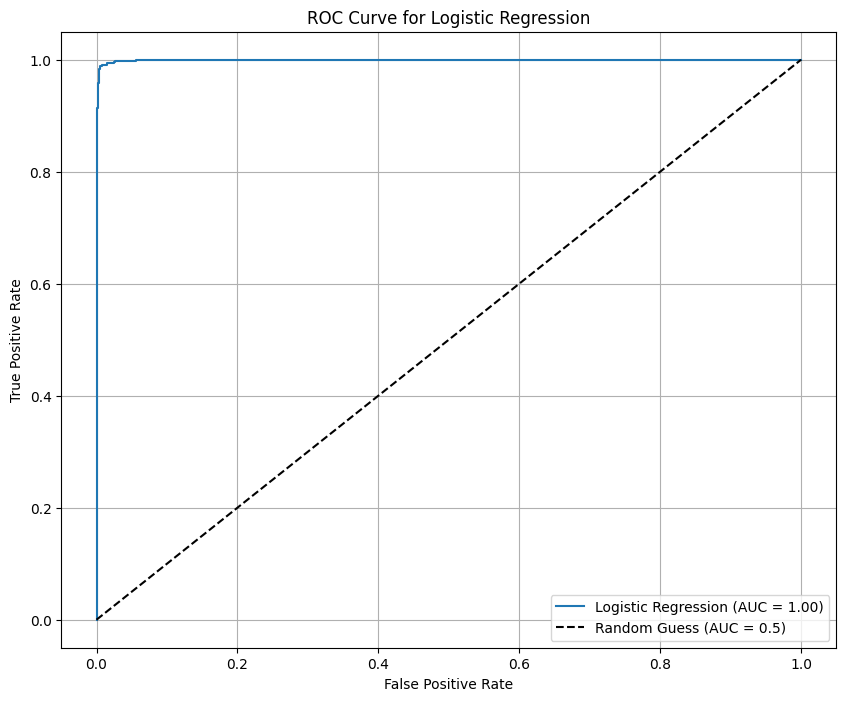

Overall ROC AUC for Logistic Regression: 0.9994


In [57]:
y_score = LR.predict_proba(x_test)[:, 1]

fpr, tpr, _ = roc_curve(y_test, y_score)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(10, 8))
plt.plot(fpr, tpr, label=f"Logistic Regression (AUC = {roc_auc:.2f})")

plt.plot([0, 1], [0, 1], 'k--', label="Random Guess (AUC = 0.5)")

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve for Logistic Regression")
plt.legend(loc="lower right")
plt.grid()
plt.show()

print(f"Overall ROC AUC for Logistic Regression: {roc_auc:.4f}")

data_to_save_LR = {
    "predictions": y_score,
    "fpr": fpr,
    "tpr": tpr,
    "roc_auc": roc_auc
}

# Save the data to a pickle file
with open("roc_data_LR.pkl", "wb") as f:
    pickle.dump(data_to_save_LR, f)

##### ROC-CURVE of KNeighbors

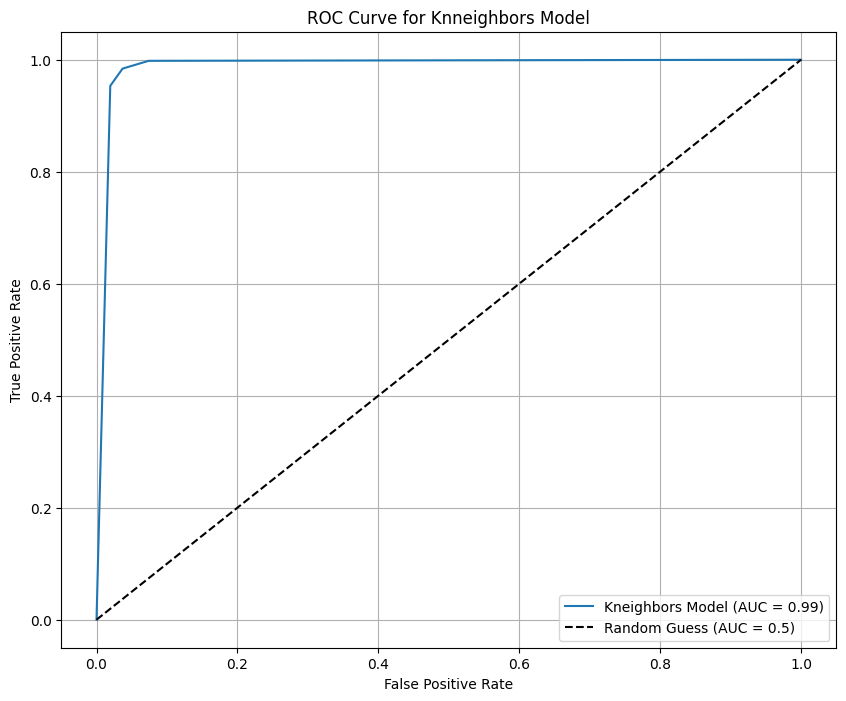

Overall ROC AUC for Kneighbors Model: 0.9880


In [58]:
y_score = KNN.predict_proba(x_test)[:, 1]

fpr, tpr, _ = roc_curve(y_test, y_score)  
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(10, 8))
plt.plot(fpr, tpr, label=f"Kneighbors Model (AUC = {roc_auc:.2f})")

plt.plot([0, 1], [0, 1], 'k--', label="Random Guess (AUC = 0.5)")

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve for Knneighbors Model")
plt.legend(loc="lower right")
plt.grid()
plt.show()

print(f"Overall ROC AUC for Kneighbors Model: {roc_auc:.4f}")

data_to_save_KNN = {
    "predictions": y_score,
    "fpr": fpr,
    "tpr": tpr,
    "roc_auc": roc_auc
}

# Save the data to a pickle file
with open("roc_data_KNN.pkl", "wb") as f:
    pickle.dump(data_to_save_KNN, f)

##### ROC-CURVE of Random Forest

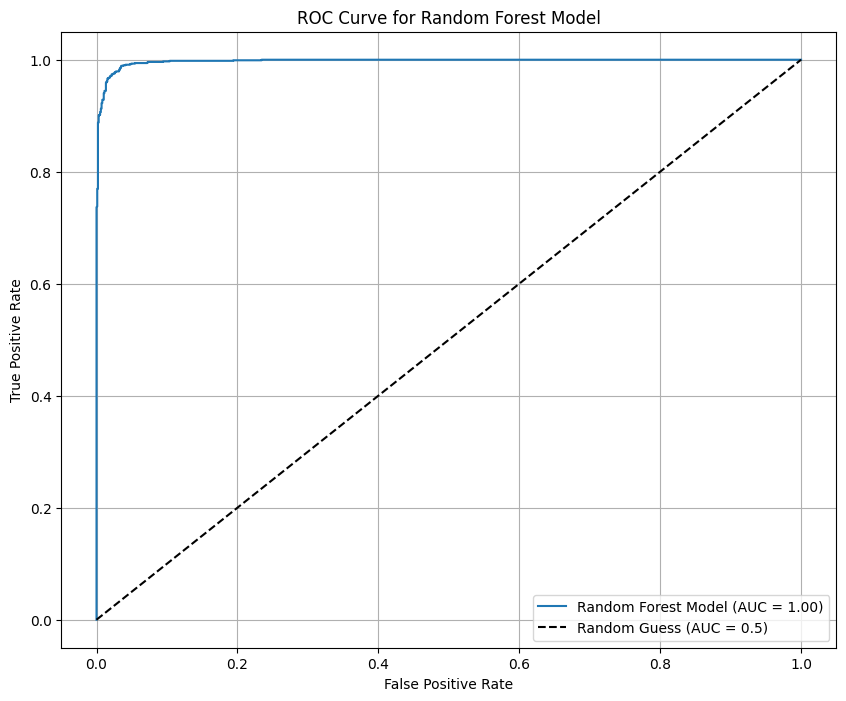

Overall ROC AUC for Random Forest Model: 0.9974


In [59]:
y_score = RF.predict_proba(x_test)[:, 1]  

fpr, tpr, _ = roc_curve(y_test, y_score)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(10, 8))
plt.plot(fpr, tpr, label=f"Random Forest Model (AUC = {roc_auc:.2f})")

plt.plot([0, 1], [0, 1], 'k--', label="Random Guess (AUC = 0.5)")

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve for Random Forest Model")
plt.legend(loc="lower right")
plt.grid()
plt.show()

print(f"Overall ROC AUC for Random Forest Model: {roc_auc:.4f}")

data_to_save_RF = {
    "predictions": y_score,
    "fpr": fpr,
    "tpr": tpr,
    "roc_auc": roc_auc
}

# Save the data to a pickle file
with open("roc_data_RF.pkl", "wb") as f:
    pickle.dump(data_to_save_RF, f)

##### ROC-CURVE of SVC

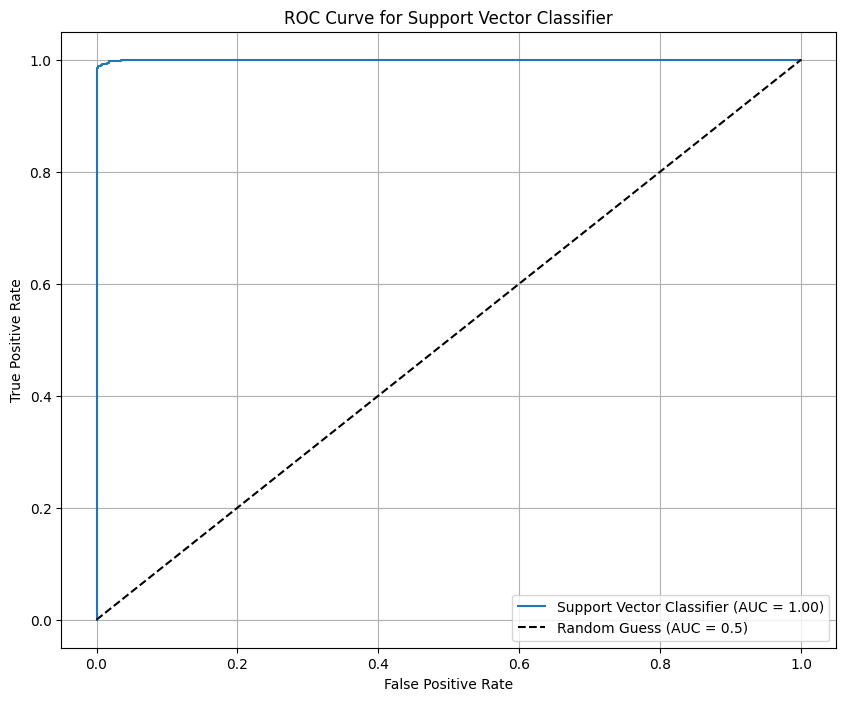

Overall ROC AUC for Support Vector Classifier Model: 0.9997


In [60]:
y_score = svc.decision_function(x_test)

fpr, tpr, _ = roc_curve(y_test, y_score)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(10, 8))
plt.plot(fpr, tpr, label=f"Support Vector Classifier (AUC = {roc_auc:.2f})")

plt.plot([0, 1], [0, 1], 'k--', label="Random Guess (AUC = 0.5)")

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve for Support Vector Classifier")
plt.legend(loc="lower right")
plt.grid()
plt.show()

print(f"Overall ROC AUC for Support Vector Classifier Model: {roc_auc:.4f}")

data_to_save_svc = {
    "predictions": y_score,
    "fpr": fpr,
    "tpr": tpr,
    "roc_auc": roc_auc
}

# Save the data to a pickle file
with open("roc_data_svc.pkl", "wb") as f:
    pickle.dump(data_to_save_svc, f)

##### ROC-CURVE of NAIVE BAYES

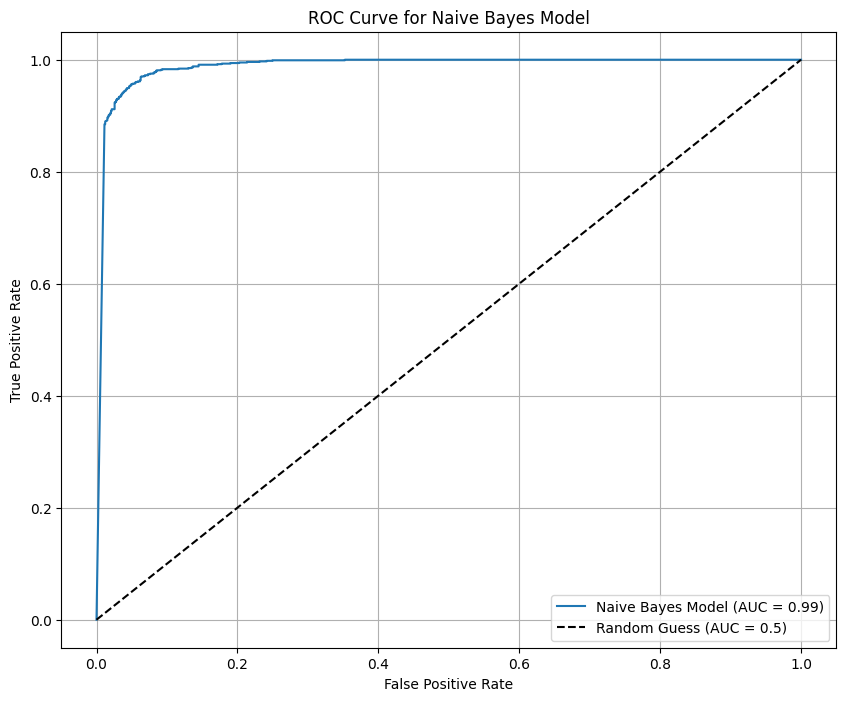

Overall ROC AUC for Naive Bayes Model: 0.9880


In [61]:
y_score = NB.predict_proba(x_test)[:, 1]

fpr, tpr, _ = roc_curve(y_test, y_score)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(10, 8))
plt.plot(fpr, tpr, label=f"Naive Bayes Model (AUC = {roc_auc:.2f})")

plt.plot([0, 1], [0, 1], 'k--', label="Random Guess (AUC = 0.5)")

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve for Naive Bayes Model")
plt.legend(loc="lower right")
plt.grid()
plt.show()

print(f"Overall ROC AUC for Naive Bayes Model: {roc_auc:.4f}")

data_to_save_NB = {
    "predictions": y_score,
    "fpr": fpr,
    "tpr": tpr,
    "roc_auc": roc_auc
}

# Save the data to a pickle file
with open("roc_data_NB.pkl", "wb") as f:
    pickle.dump(data_to_save_NB, f)

##### ROC-CURVE of XGBOOST

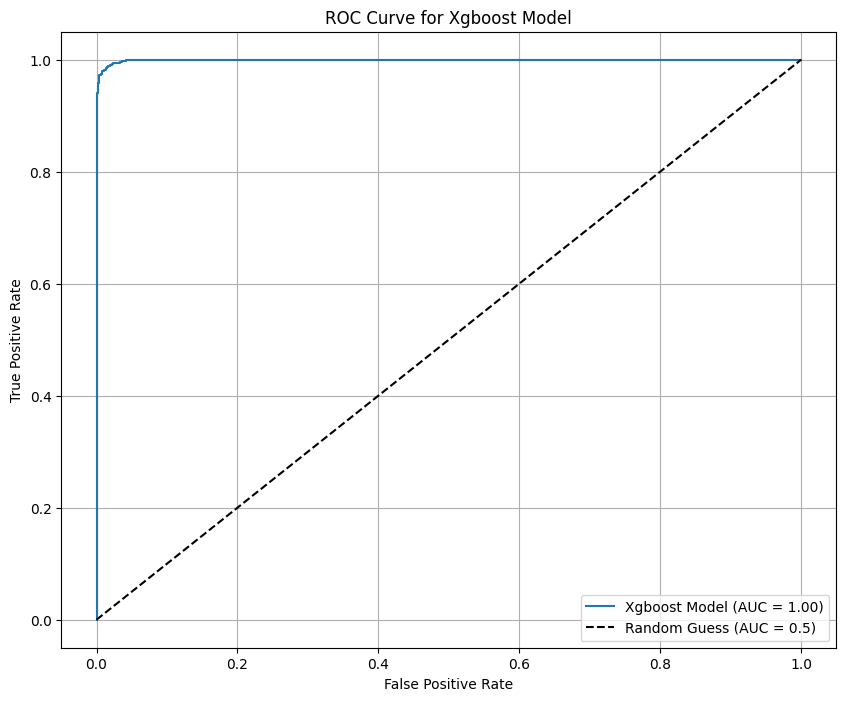

Overall ROC AUC for XGBoost Model: 0.9993


In [62]:
y_score = xgb.predict_proba(x_test)[:, 1]

fpr, tpr, _ = roc_curve(y_test, y_score)  
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(10, 8))
plt.plot(fpr, tpr, label=f"Xgboost Model (AUC = {roc_auc:.2f})")

plt.plot([0, 1], [0, 1], 'k--', label="Random Guess (AUC = 0.5)")

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve for Xgboost Model")
plt.legend(loc="lower right")
plt.grid()
plt.show()

print(f"Overall ROC AUC for XGBoost Model: {roc_auc:.4f}")

data_to_save_xgb = {
    "predictions": y_score,
    "fpr": fpr,
    "tpr": tpr,
    "roc_auc": roc_auc
}

# Save the data to a pickle file
with open("roc_data_xgb.pkl", "wb") as f:
    pickle.dump(data_to_save_xgb, f)

#### Classification Report

##### Logistic Regression

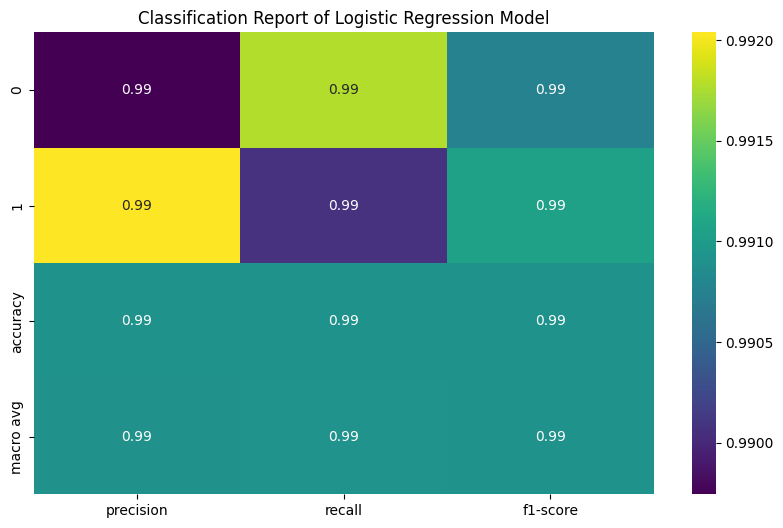

In [63]:
LR_report = classification_report(y_test, LR_pred, output_dict=True)
LR_report_df = pd.DataFrame(LR_report).transpose()

plt.figure(figsize=(10, 6))
sns.heatmap(LR_report_df.iloc[:-1, :-1], annot=True, cmap='viridis', fmt=".2f")
plt.title("Classification Report of Logistic Regression Model")
plt.show()

with open("classification_LR.pkl", "wb") as f:
    pickle.dump(LR_report_df, f)

##### KNeighbors

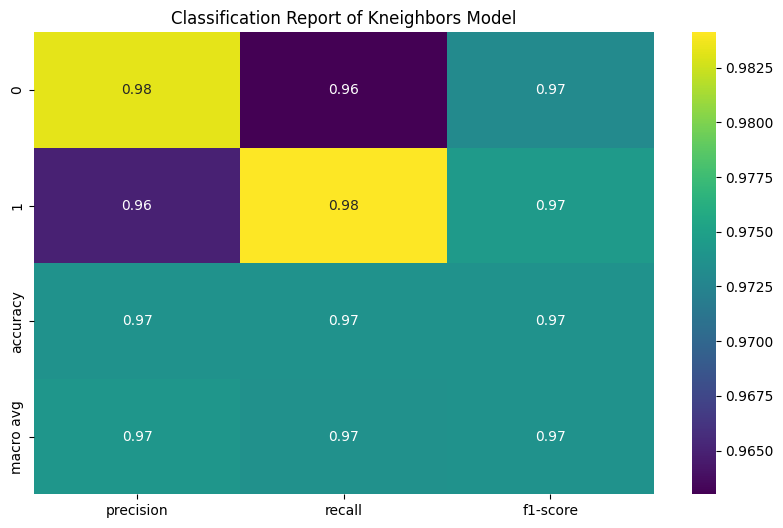

In [64]:
KN_report = classification_report(y_test, KNN_pred, output_dict=True)
KN_report_df = pd.DataFrame(KN_report).transpose()

plt.figure(figsize=(10, 6))
sns.heatmap(KN_report_df.iloc[:-1, :-1], annot=True, cmap='viridis', fmt=".2f")
plt.title("Classification Report of Kneighbors Model")
plt.show()

with open("classification_KNN.pkl", "wb") as f:
    pickle.dump(KN_report_df, f)

##### SVC

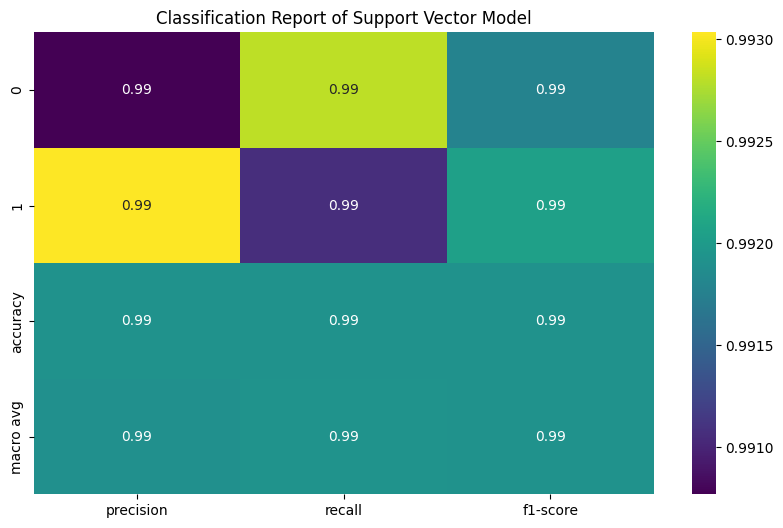

In [65]:
SVC_report = classification_report(y_test, svc_pred, output_dict=True)
SVC_report_df = pd.DataFrame(SVC_report).transpose()

plt.figure(figsize=(10, 6))
sns.heatmap(SVC_report_df.iloc[:-1, :-1], annot=True, cmap='viridis', fmt=".2f")
plt.title("Classification Report of Support Vector Model")
plt.show()


with open("classification_svc.pkl", "wb") as f:
    pickle.dump(SVC_report_df, f)


##### Naive Bayes

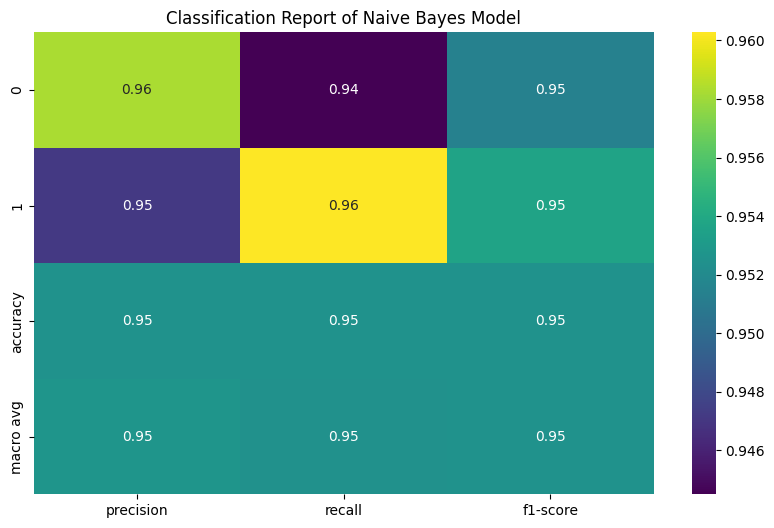

In [66]:
NB_report = classification_report(y_test, NB_pred, output_dict=True)
NB_report_df = pd.DataFrame(NB_report).transpose()

plt.figure(figsize=(10, 6))
sns.heatmap(NB_report_df.iloc[:-1, :-1], annot=True, cmap='viridis', fmt=".2f")
plt.title("Classification Report of Naive Bayes Model")
plt.show()

with open("classification_NB.pkl", "wb") as f:
    pickle.dump(NB_report_df, f)

##### Random Forest

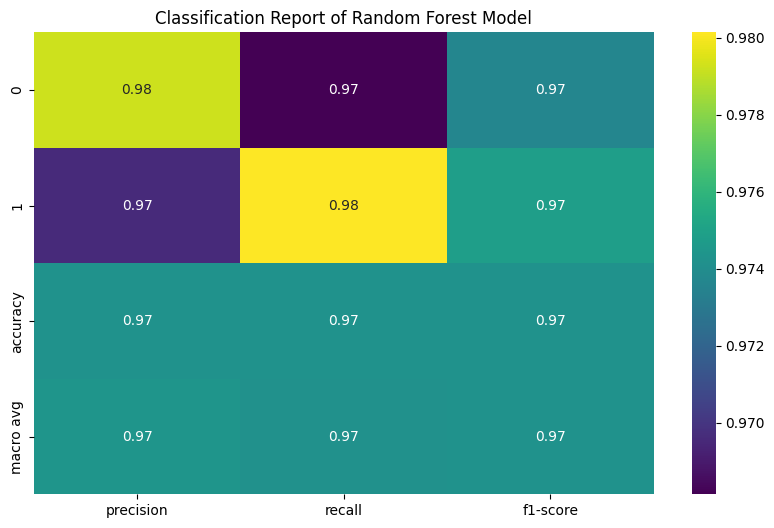

In [67]:
RF_report = classification_report(y_test, RF_pred, output_dict=True)
RF_report_df = pd.DataFrame(RF_report).transpose()

plt.figure(figsize=(10, 6))
sns.heatmap(RF_report_df.iloc[:-1, :-1], annot=True, cmap='viridis', fmt=".2f")
plt.title("Classification Report of Random Forest Model")
plt.show()


with open("classification_RF.pkl", "wb") as f:
    pickle.dump(RF_report_df, f)

##### XGBOOST

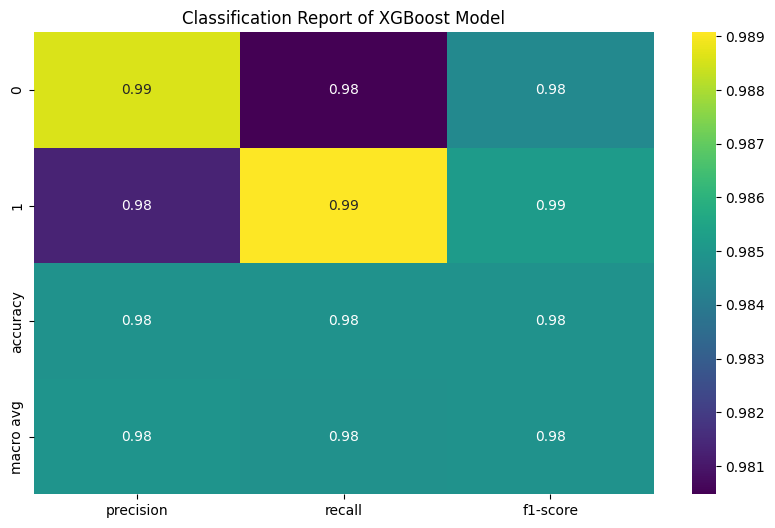

In [68]:
xgb_report = classification_report(y_test, xgb_pred, output_dict=True)
xgb_report_df = pd.DataFrame(xgb_report).transpose()

plt.figure(figsize=(10, 6))
sns.heatmap(xgb_report_df.iloc[:-1, :-1], annot=True, cmap='viridis', fmt=".2f")
plt.title("Classification Report of XGBoost Model")
plt.show()

with open("classification_xgb.pkl", "wb") as f:
    pickle.dump(xgb_report_df, f)

#### Confusion Matrix

##### Logistic Regression

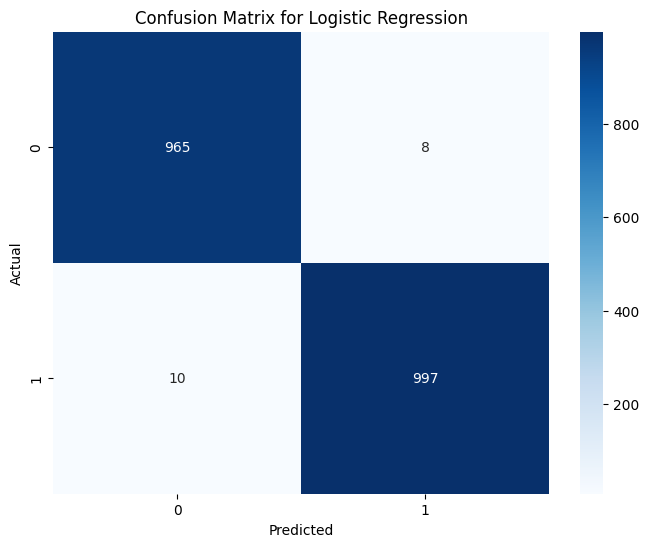

In [69]:
y_test_pred = LR.predict(x_test)
cm = confusion_matrix(y_test, y_test_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap='Blues')
plt.title('Confusion Matrix for Logistic Regression')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

with open("confusion_LR.pkl", "wb") as f:
    pickle.dump(cm, f)

##### KNeighbors

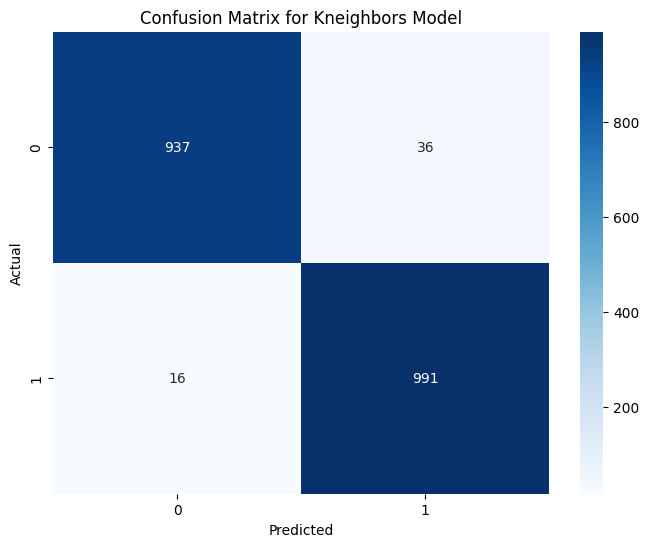

In [70]:
y_test_pred = KNN.predict(x_test)
cm = confusion_matrix(y_test, y_test_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap='Blues')
plt.title('Confusion Matrix for Kneighbors Model')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

with open("confusion_KNN.pkl", "wb") as f:
    pickle.dump(cm, f)

##### SVC

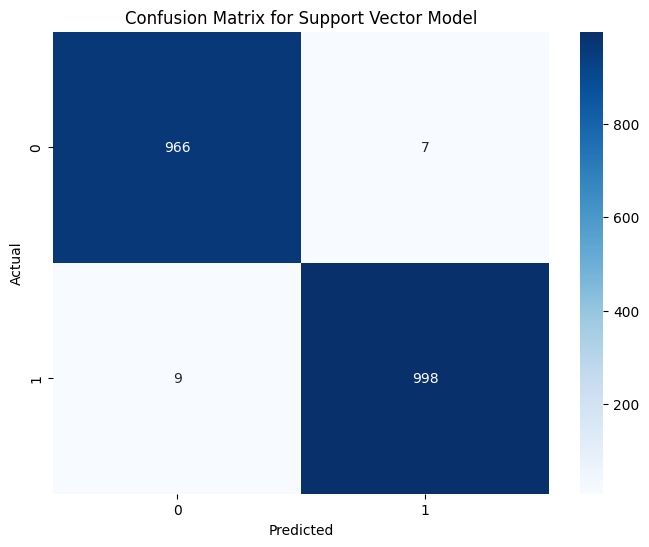

In [71]:
y_test_pred = svc.predict(x_test)
cm = confusion_matrix(y_test, y_test_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap='Blues')
plt.title('Confusion Matrix for Support Vector Model')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

with open("confusion_svc.pkl", "wb") as f:
    pickle.dump(cm, f)

##### Random Forest

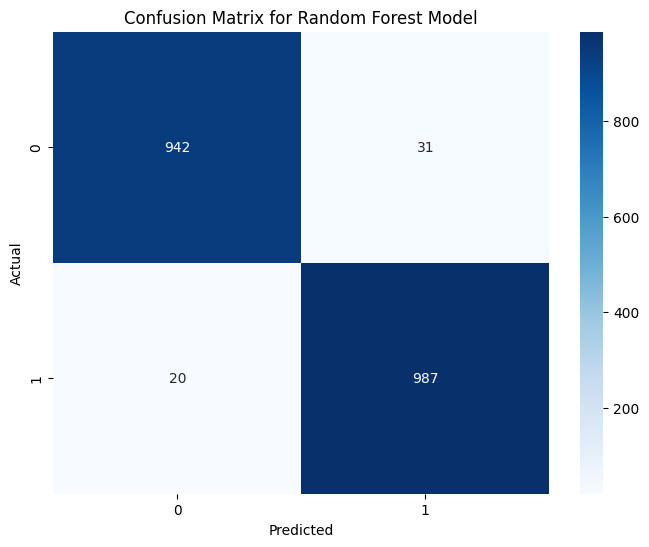

In [72]:
y_test_pred = RF.predict(x_test)
cm = confusion_matrix(y_test, y_test_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap='Blues')
plt.title('Confusion Matrix for Random Forest Model')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

with open("confusion_RF.pkl", "wb") as f:
    pickle.dump(cm, f)

##### XGBoost

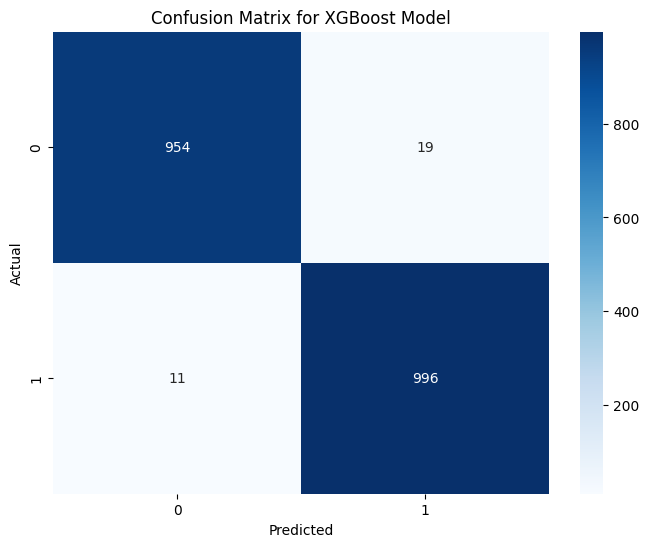

In [73]:
y_test_pred = xgb.predict(x_test)
cm = confusion_matrix(y_test, y_test_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap='Blues')
plt.title('Confusion Matrix for XGBoost Model')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

with open("confusion_xgb.pkl", "wb") as f:
    pickle.dump(cm, f)

##### Naive Bayes

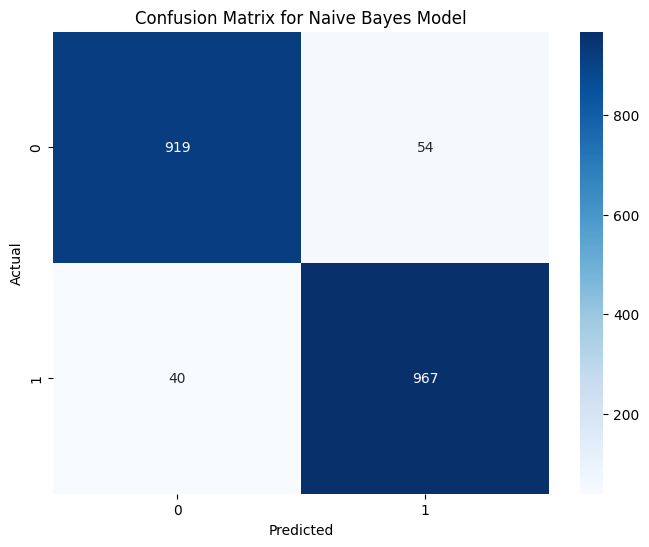

In [74]:
y_test_pred = NB.predict(x_test)
cm = confusion_matrix(y_test, y_test_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap='Blues')
plt.title('Confusion Matrix for Naive Bayes Model')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

with open("confusion_NB.pkl", "wb") as f:
    pickle.dump(cm, f)

#### Accuracy

In [75]:
models = {
    'Logistic Regression': LR,
    'Random Forest': RF,
    'SVM': svc,
    'Kneighbors Classifier': KNN,
    'Xgboost':xgb
}

/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


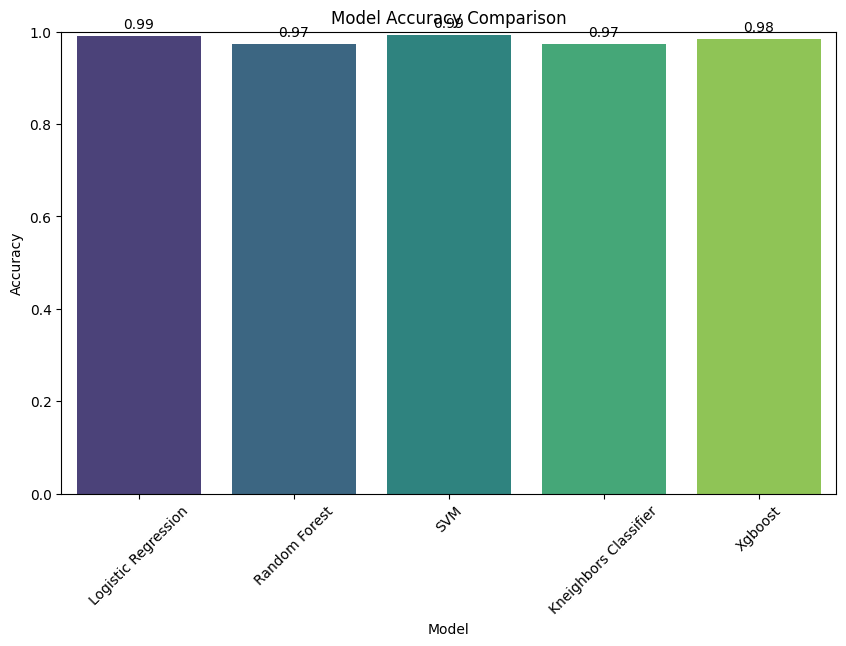

In [76]:
models = {
    'Logistic Regression': LR,
    'Random Forest': RF,
    'SVM': svc,
    'Kneighbors Classifier': KNN,
    'Xgboost':xgb
}
accuracies = {}

for model_name, model in models.items():
    y_test_pred = model.predict(x_test)
    accuracy = accuracy_score(y_test, y_test_pred)
    accuracies[model_name] = accuracy

plt.figure(figsize=(10, 6))
sns.barplot(x=list(accuracies.keys()), y=list(accuracies.values()), palette="viridis")

for i, (model_name, accuracy) in enumerate(accuracies.items()):
    plt.text(i, accuracy + 0.01, f"{accuracy:.2f}", ha='center', va='bottom', fontsize=10)

plt.title("Model Accuracy Comparison")
plt.xlabel("Model")
plt.ylabel("Accuracy")
plt.ylim(0, 1)
plt.xticks(rotation=45)
plt.show()

### Neural Network

In [77]:
model = Sequential()

In [78]:
model.add(Dense(128, activation='relu', input_shape=(100,)))
model.add(Dropout(0.5))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [79]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 128)                 │          12,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 21,249 (83.00 KB)

 Trainable params: 21,249 (83.00 KB)

 Non-trainable params: 0 (0.00 B)

In [80]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [81]:
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-6)

In [82]:
callback=EarlyStopping(
    monitor="val_loss",
    min_delta=0.0001,
    patience=15,
    verbose=1,
    mode="auto",
    restore_best_weights=True,
    start_from_epoch=0,
)

In [83]:
fit_hist= model.fit(x_train, y_train, epochs=500, batch_size=32, validation_split=0.2, callbacks=[reduce_lr,callback])

Epoch 1/500
198/198 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.8493 - loss: 0.3324 - val_accuracy: 0.9741 - val_loss: 0.0690 - learning_rate: 0.0010
Epoch 2/500
198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9668 - loss: 0.0978 - val_accuracy: 0.9836 - val_loss: 0.0471 - learning_rate: 0.0010
Epoch 3/500
198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9738 - loss: 0.0702 - val_accuracy: 0.9842 - val_loss: 0.0458 - learning_rate: 0.0010
Epoch 4/500
198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9764 - loss: 0.0663 - val_accuracy: 0.9886 - val_loss: 0.0363 - learning_rate: 0.0010
Epoch 5/500
198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9805 - loss: 0.0528 - val_accuracy: 0.9899 - val_loss: 0.0331 - learning_rate: 0.0010
Epoch 6/500
198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9817 - loss: 0.0540 - val_accuracy: 0.9880 - val_loss: 0.0357 - learning_rate: 0.0010
Epoch 7/500
198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9838 - loss: 0.

In [84]:
model.save('Fakenews.h5')

## Model Evaluation

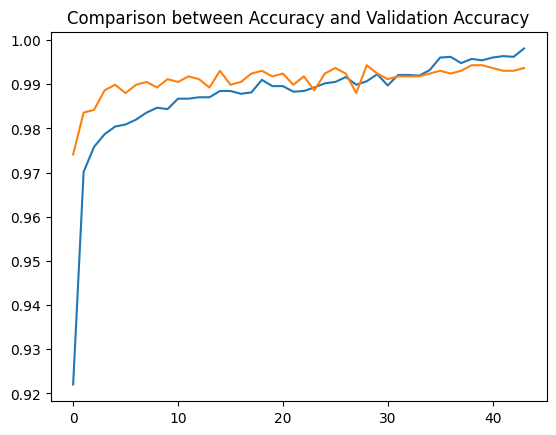

In [85]:
plt.plot(fit_hist.history['accuracy'])
plt.plot(fit_hist.history['val_accuracy'])
plt.title('Comparison between Accuracy and Validation Accuracy')
plt.show()

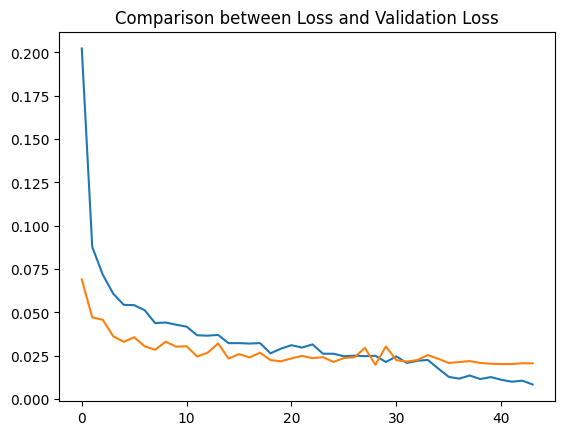

In [86]:
plt.plot(fit_hist.history['loss'])
plt.plot(fit_hist.history['val_loss'])
plt.title('Comparison between Loss and Validation Loss')
plt.show()

In [87]:
y_pred = model.predict(x_test)

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step


In [88]:
y_pred_classes = (y_pred > 0.5).astype(int)

In [89]:
accuracy_neural = accuracy_score(y_test, y_pred_classes)
accuracy_neural

0.9929292929292929

In [90]:
with open("accuracy_neural.pkl", "wb") as f:
    pickle.dump(accuracy_neural, f)

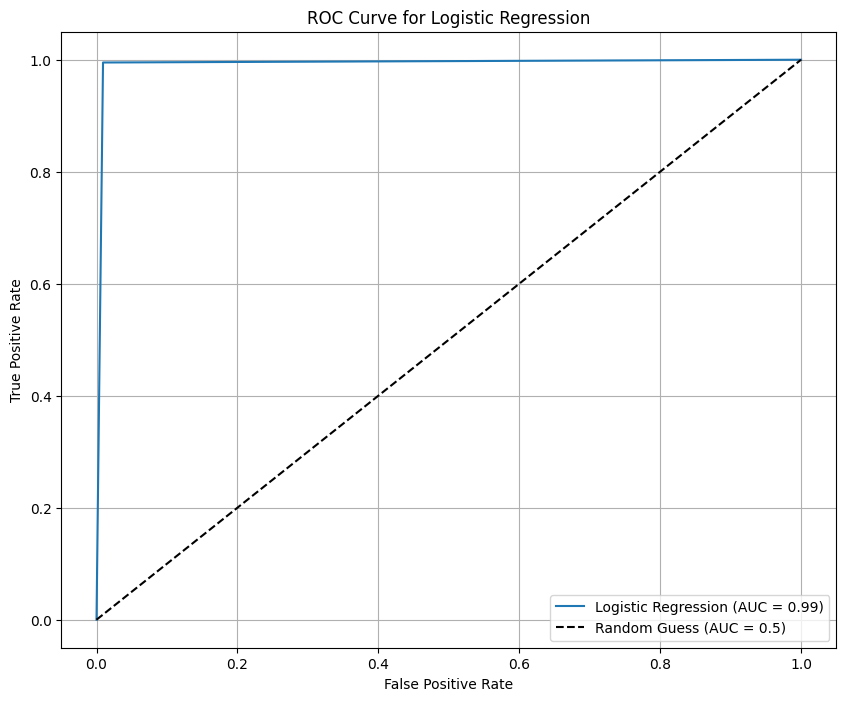

Overall ROC AUC for Logistic Regression: 0.9929


In [91]:
y_score = y_pred_classes

fpr, tpr, _ = roc_curve(y_test, y_score)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(10, 8))
plt.plot(fpr, tpr, label=f"Logistic Regression (AUC = {roc_auc:.2f})")

plt.plot([0, 1], [0, 1], 'k--', label="Random Guess (AUC = 0.5)")

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve for Logistic Regression")
plt.legend(loc="lower right")
plt.grid()
plt.show()

print(f"Overall ROC AUC for Logistic Regression: {roc_auc:.4f}")

data_to_save_neural = {
    "predictions": y_score,
    "fpr": fpr,
    "tpr": tpr,
    "roc_auc": roc_auc
}

with open("roc_data_neural.pkl", "wb") as f:
    pickle.dump(data_to_save_neural, f)

In [92]:
from sklearn.metrics import confusion_matrix
neural_cm =  confusion_matrix(y_test, y_pred_classes)

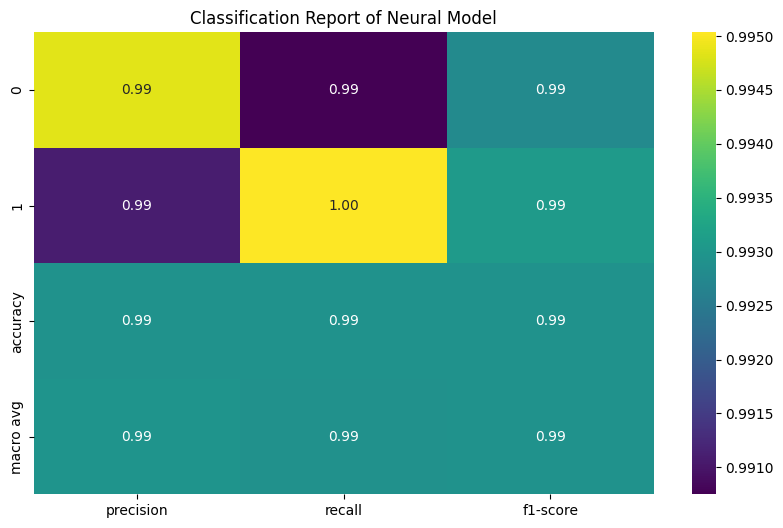

In [93]:
Neural_report = classification_report(y_test, y_pred_classes, output_dict=True)
Neural_report_df = pd.DataFrame(Neural_report).transpose()

plt.figure(figsize=(10, 6))
sns.heatmap(Neural_report_df.iloc[:-1, :-1], annot=True, cmap='viridis', fmt=".2f")
plt.title("Classification Report of Neural Model")
plt.show()

with open("classification_Neural.pkl", "wb") as f:
    pickle.dump(Neural_report_df, f)

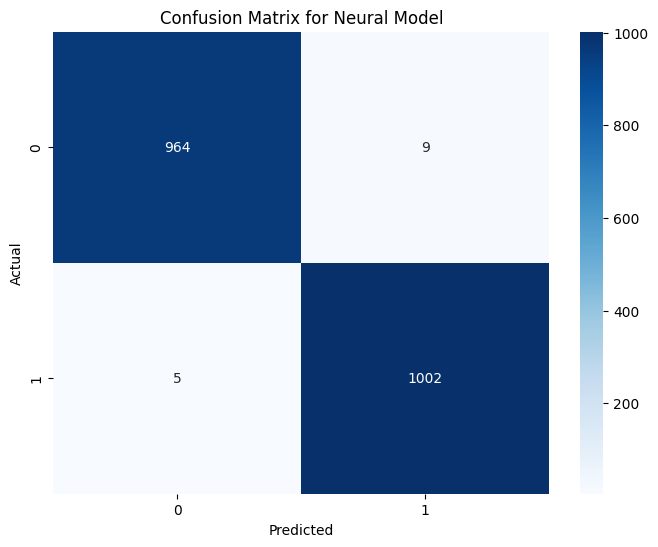

In [94]:
cm = confusion_matrix(y_test, y_pred_classes)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap='Blues')
plt.title('Confusion Matrix for Neural Model')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

with open("confusion_Neural.pkl", "wb") as f:
    pickle.dump(cm, f)

62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


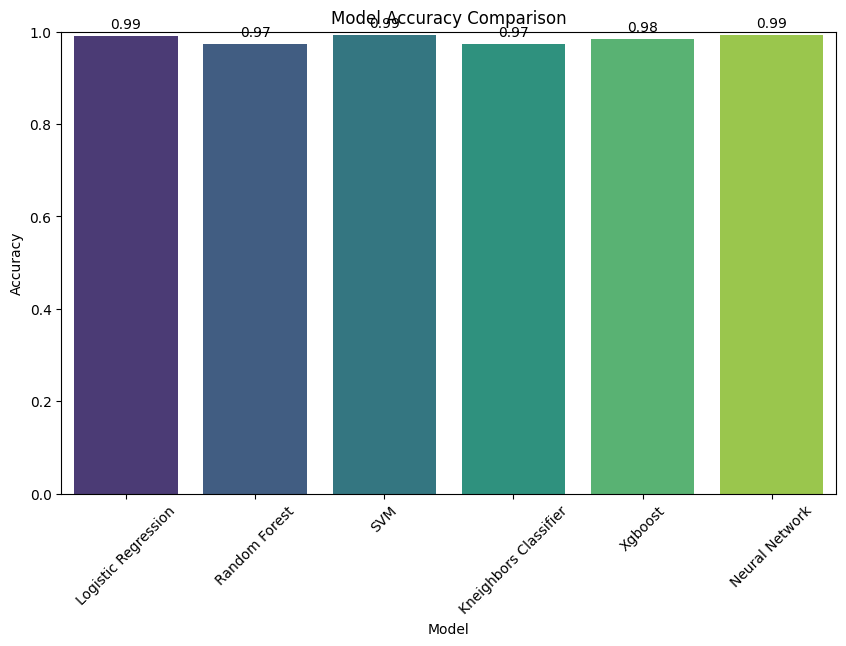

Plot saved as a pickle file: accuracy_comparison_plot.pkl


In [95]:
import pickle
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Define the models
models = {
    'Logistic Regression': LR,
    'Random Forest': RF,
    'SVM': svc,
    'Kneighbors Classifier': KNN,
    'Xgboost': xgb,
    'Neural Network': model
}

accuracies = {}

for model_name, model in models.items():
    if model_name == 'Neural Network':
        y_test_pred = model.predict(x_test)
        y_test_pred = (y_test_pred > 0.5).astype(int)
    else:
        y_test_pred = model.predict(x_test)
    
    accuracy = accuracy_score(y_test, y_test_pred)
    accuracies[model_name] = accuracy

plt.figure(figsize=(10, 6))
sns.barplot(x=list(accuracies.keys()), y=list(accuracies.values()), palette="viridis")

for i, (model_name, accuracy) in enumerate(accuracies.items()):
    plt.text(i, accuracy + 0.01, f"{accuracy:.2f}", ha='center', va='bottom', fontsize=10)

plt.title("Model Accuracy Comparison")
plt.xlabel("Model")
plt.ylabel("Accuracy")
plt.ylim(0, 1)
plt.xticks(rotation=45)

plot_pickle_path = "accuracy_comparison_plot.pkl"
with open(plot_pickle_path, 'wb') as file:
    pickle.dump(plt.gcf(), file)

plt.show()

print(f"Plot saved as a pickle file: {plot_pickle_path}")

In [96]:
# with open("accuracy_comparison_plot.pkl", 'rb') as file:
#     loaded_plot = pickle.load(file)

# loaded_plot.show()